<a href="https://colab.research.google.com/github/MathieuGrosso/machine-learning-/blob/main/extracting_features_EfficientNetB4_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import sys
print(sys.version)

import matplotlib.pyplot as plt
import numpy as np
from sklearn.manifold import TSNE, Isomap, MDS

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten, Reshape

from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import metrics
from tensorflow.keras.datasets import mnist, fashion_mnist
from tensorflow.keras.layers.experimental import preprocessing
import cv2
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import roc_curve,auc,roc_auc_score

from tensorflow.keras.utils import to_categorical

3.7.10 (default, Feb 20 2021, 21:17:23) 
[GCC 7.5.0]


#Data

##Loading data: 

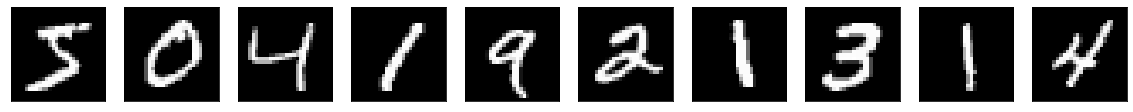

In [5]:
#import data of mnist and fashion mnist: 
dataset = "numbers" # "numbers" or "fashion"
anomaly_class = 8  # indicates which class is considered as anomalous

if dataset == "numbers":
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    dico = {
            0: '0',
            1: '1',
            2: '2',
            3: '3',
            4: '4',
            5: '5',
            6: '6',
            7: '7',
            8: '8',
            9: '9',
    }
elif dataset =="fashion":
    (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
    dico = {
            0: 'T-shirt/top',
            1: 'Trouser/pants',
            2: 'Pullover shirt',
            3: 'Dress',
            4: 'Coat',
            5: 'Sandal',
            6: 'Shirt',
            7: 'Sneaker',
            8: 'Bag',
            9: 'Ankle boot',
    }
else:
    print("Error: choices are 'fashion' or 'numbers'")

#We only keep normal images in the training set
#J'ai enlevé ces deux lignes pour le moment pour essayer de déjà faire marcher l'algo en version supervised
x_train = x_train[y_train != anomaly_class]
y_train = y_train[y_train != anomaly_class]

# Normalization and shape configuration
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.expand_dims(x_train, axis=3)
x_test = np.expand_dims(x_test, axis=3)

# Display some NORMAL images
n = 10  # how many images we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(1, n, i + 1)
    plt.imshow(x_train[i].reshape(28,28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

plt.show()

In [6]:
print(x_train.shape, 'x train samples')
print(x_test.shape, 'x test samples')
print(y_train.shape, 'y train samples')
print(y_test.shape, 'y test samples')

(54149, 28, 28, 1) x train samples
(10000, 28, 28, 1) x test samples
(54149,) y train samples
(10000,) y test samples


##Preprocessing the data: 


In [7]:
#faire qu'il n'y ait que deux classes: 1,2,3,4,5,6,7 et 9 sont normaux et 8 anormal. on va noter la classe 8=1 et lesa utres =0. 


In [8]:
#change the format of MNIST DATA : 

x_train_rgb, x_test_rgb = np.squeeze(x_train,axis=3), np.squeeze(x_test,axis=3) #(54149,28,28)
print(x_train_rgb.shape)
print(x_test_rgb.shape)


(54149, 28, 28)
(10000, 28, 28)


In [9]:
#Repeat the image array 3 times on a new dimension 
x_train, x_test = np.repeat(x_train_rgb[..., np.newaxis], 3, -1), np.repeat(x_test_rgb[..., np.newaxis], 3, -1)


In [10]:
print(x_train.shape)
print(x_test.shape)

(54149, 28, 28, 3)
(10000, 28, 28, 3)


In [11]:
#Increasing the size of the image: 
#pour mnist: 
#padding: 112 x 112
#image=np.zeros(batch,x,y,canaux)
#image[b,startx:endx,starty:endy,]=x_train_aggrandi

#Créer un tableau pour y rentrer les images: 
#https://ensip.gitlab.io/pages-info/ressources/transverse/tuto_images.html (tuto)
import numpy as np
image_train = np.zeros((54149,112, 112, 3), dtype=np.uint8)
image_train[0:54149,0:28,0:28,]=x_train
x_train=image_train

image_test = np.zeros((10000,112, 112, 3), dtype=np.uint8)
image_test[0:10000,0:28,0:28,]=x_test
x_test=image_test

#padding



#padding: 112 x 112
#image=np.zeros(batch,x,y,canaux)
#image[b,startx:endx,starty:endy,]=x_train_aggrandi


In [12]:
x_train.shape

(54149, 112, 112, 3)

#Load model and extract the feature maps: 

##importation

In [13]:
#importation
import keras
from keras import layers
from tensorflow.keras import layers
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras import Sequential
import numpy as np
import os
from tensorflow.keras.applications import EfficientNetB4

##creating the base model

In [14]:

#loading the EfficientNet model: 

base_model = EfficientNetB4(weights='imagenet',include_top=False)
print(base_model.summary())

Model: "efficientnetb4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, None, None, 3 0           input_2[0][0]                    
__________________________________________________________________________________________________
normalization_1 (Normalization) (None, None, None, 3 7           rescaling_1[0][0]                
__________________________________________________________________________________________________
stem_conv_pad (ZeroPadding2D)   (None, None, None, 3 0           normalization_1[0][0]            
_____________________________________________________________________________________

##trying to extract first level feature maps

In [ ]:
#extraction feature maps pour le 1er niveau 




from tensorflow.keras import layers
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras import Sequential
import numpy as np
import os

liste=['input_1','block1b_add','block2d_add','block3d_add','block4f_add','block5f_add','block6h_add','block7b_add']


#modifier le numéro dans list[] pour changer le block créé
prev_model=Model(inputs=base_model.input, outputs=base_model.get_layer(liste[1]).output) #loading the 1st block of the previously saved model 
#print(prev_model.summary())

block1_pool_features = Sequential()
block1_pool_features.add(prev_model)
block1_pool_features.add(GlobalAveragePooling2D())
block1_pool_features.compile()

block1_pool_features.summary()

block1_train_features=block1_pool_features.predict(x_train)
block1_test_features=block1_pool_features.predict(x_test)
print(block1_train_features.shape)


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, None, None, 24)    5881      
_________________________________________________________________
global_average_pooling2d (Gl (None, 24)                0         
Total params: 5,881
Trainable params: 5,538
Non-trainable params: 343
_________________________________________________________________


## créer le modèle pour chaque niveau  :

### Utiliser le modèle fonctionnelle et séquentielle

In [18]:
#créer les modèles pour chaque niveau: 
#créer une liste contenant les features de chaque niveau

#liste=['block1b_add','block2d_add','block3d_add','block4f_add','block5f_add','block6h_add','block7b_add']
#block_train_features=[]
#block_test_features=[]



#for block in liste: 
 # prev_model=Model(inputs=base_model.input, outputs=base_model.get_layer(block).output) 
 # block1_pool_features = Sequential()
 # block1_pool_features.add(prev_model)
  #block1_pool_features.add(GlobalAveragePooling2D())
 # block1_pool_features.compile()
  #block1_pool_features.summary()
  #block1_pool_features.save("model"+block)
 # block_train_features.append(block1_pool_features.predict(x_train))
 # block_test_features.append(block1_pool_features.predict(x_test)) #predict prend en entrée un batch qui peut être consistuer d'une ou plusieurs images, cette méthode applique notre modèle M à notre batch.






  

### Utiliser la méthode fonctionnelle seulement: 

In [15]:
#utiliser la méthode fonctionnelle pour créer les différentes modèles: 
liste=['block1b_add','block2d_add','block3d_add','block4f_add','block5f_add','block6h_add','block7b_add']
block_train_features=[]
block_test_features=[]



for block in liste:
  prev_model=keras.Model(base_model.input, base_model.get_layer(block).output, name="level_without_average_pooling")
  input=base_model.input
  prev_model = prev_model(input)
  output=layers.GlobalAveragePooling2D()(prev_model)
  model=keras.Model(input,output,name=(block))
  model.summary()
  model.save(block)
  block_train_features.append(model.predict(x_train))
  block_test_features.append(model.predict(x_test)) 




  









Model: "block1b_add"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
level_without_average_poolin (None, None, None, 24)    5881      
_________________________________________________________________
global_average_pooling2d_1 ( (None, 24)                0         
Total params: 5,881
Trainable params: 5,538
Non-trainable params: 343
_________________________________________________________________
Model: "block2d_add"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, None, None, 3)]   0         
_________________________________________________________________
level_without_average_poolin (None, None, None, 32)    75255     
______________________________

In [17]:
#essayer avec le modèle fonctionnelle et multi outputs: 
#liste=['block1b_add','block2d_add','block3d_add','block4f_add','block5f_add','block6h_add','block7b_add']


#prev_model=keras.Model(base_model.get_layer('rescaling').input, [base_model.get_layer(liste[0]).output,base_model.get_layer(liste[1]).output,base_model.get_layer(liste[2]).output,base_model.get_layer(liste[3]).output,base_model.get_layer(liste[4]).output,base_model.get_layer(liste[5]).output,base_model.get_layer(liste[6]).output], name="level_without_average_pooling")


#input=base_model.input
#prev_model = prev_model(input)
#output=layers.GlobalAveragePooling2D()(prev_model)
#model=keras.Model(input,prev_model,name=(block))
#model.summary()

#keras.utils.plot_model(prev_model, show_shapes=True)




In [16]:
print(block_train_features[1])
print(block_test_features[2])

[[ -2.174453    1.4400759   5.8320174 ...   1.9678156 -15.470801
  -11.4379   ]
 [ -2.1745012   1.4399588   5.831952  ...   1.967824  -15.47057
  -11.4379015]
 [ -2.1745644   1.4399939   5.8320985 ...   1.9676571 -15.470264
  -11.4380455]
 ...
 [ -2.1744342   1.4399619   5.831985  ...   1.9679154 -15.470593
  -11.437886 ]
 [ -2.174585    1.4401479   5.832106  ...   1.9667683 -15.470509
  -11.437813 ]
 [ -2.1744409   1.4399285   5.8319798 ...   1.9679179 -15.470654
  -11.437919 ]]
[[ 6.526196  -5.559645  -3.0814545 ...  2.1597211 -6.9265313 -5.80431  ]
 [ 6.5263343 -5.5597405 -3.0815442 ...  2.1599727 -6.926522  -5.8043075]
 [ 6.5262547 -5.5596313 -3.0814369 ...  2.1601129 -6.9263964 -5.8046074]
 ...
 [ 6.5262113 -5.559872  -3.0815074 ...  2.159964  -6.9265733 -5.804218 ]
 [ 6.526255  -5.5595527 -3.0814502 ...  2.1601722 -6.926737  -5.804495 ]
 [ 6.526335  -5.5597053 -3.0815744 ...  2.1601865 -6.926835  -5.804142 ]]


### Save the model for later…

In [ ]:

#load chaque modèle pour chaque niveau: 
for block in liste: 
  keras.models.load_model(block)


On a obtenu un vecteur pour chaque niveau. Ce vecteur sera considéré  comme une représentation de l'image d'entrée.

Dans cet espace de  représentation on va utiliser la distance de mahalanobis pour évaluer le dégré d'anomalie de chaque image. 


 **Visualizing the results of the feature maps**:

In [ ]:
#faire un graph pour visualiser: 


#Mahalanobis Distance: 


## test pour le level 1: 

In [22]:
# Using Mahalanobis Distance as Anomaly Detector
from sklearn.covariance import EmpiricalCovariance
#on calcule la distribution pour le train set (avec que des classes normales)
emp_cov = EmpiricalCovariance().fit(block_train_features[0]) #calcul de la symetric covariance matrix of the distribution



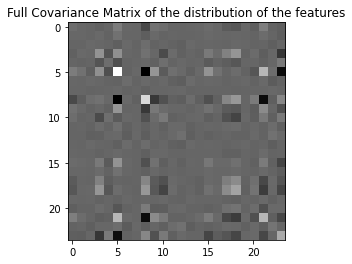

In [25]:
plt.figure()
plt.title('Full Covariance Matrix of the distribution of the features')
plt.imshow(emp_cov.covariance_)
plt.show()


In [26]:
#puis on applique la distance de mahalanobis sur le test set en utilisant la distribution du train set. 
distMahalanobis=emp_cov.mahalanobis(block_test_features[0])

print(distMahalanobis.shape)
print(distMahalanobis)

# Faire attention à : on a une base de données, on a un cts nombre de points et chaque point à une dimension, il faut prendre la matrice ds le bon ordre et pas qu'il confonde les deux. 
#dimension de la matrice de covariance.
#distance correspond au score d'anomalie. 
#log pas d'intérêt. 
#

(10000,)
[30452208.86058575 30487455.12440107 30448691.402778   ...
 30448565.13381563 30437844.85897345 30445363.01535683]


## calcul pour chaque level:

In [28]:
from sklearn.covariance import EmpiricalCovariance

feature_level=[1,2,3,4,5,6,7]
res_maha=[]

for k in feature_level:
    errs = []
    level = k
    z_train = block_train_features[k-1]
    z_test = block_test_features[k-1]
    emp_cov = EmpiricalCovariance().fit(z_train)
    errs = emp_cov.mahalanobis(z_test)
    res_maha.append(roc_auc_score(y_test==0, errs)) #8 est la classe anormale #regardez doc pour la fonction roc_auc_score. 

    print('The the AUC score for level %d is %.2f' % (k, res_maha[-1]))

The the AUC score for level 1 is 0.50
The the AUC score for level 2 is 0.47
The the AUC score for level 3 is 0.54
The the AUC score for level 4 is 0.44
The the AUC score for level 5 is 0.50
The the AUC score for level 6 is 0.49
The the AUC score for level 7 is 0.52


The best level is 4, whose AUC score is 0.73


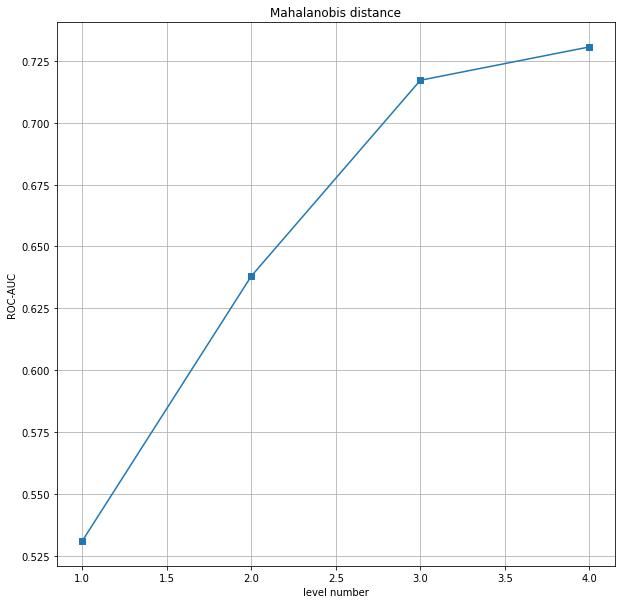

In [ ]:
plt.figure(figsize=(10, 10))
plt.plot(feature_level, res_maha, 's-')
best_res = max(res_maha)
best_dim = feature_level[np.argmax(res_maha)]
print('The best level is %d, whose AUC score is %.2f' % (best_dim, best_res))

plt.xlabel('level number')
plt.title('Mahalanobis distance')
plt.ylabel('ROC-AUC')
plt.grid('on')
plt.show()



In [ ]:
#the best level is 2, let's analyze it:

# the best model is 2, let's analyse it: 
level=2

z_train = model_2.predict(x_train, batch_size=64)
z_test = model_2.predict(x_test, batch_size=64)
emp_cov = EmpiricalCovariance().fit(z_train)

errs = np.log(emp_cov.mahalanobis(z_test))





Reconstruction error for label 0 : 3.727909 
Reconstruction error for label 1 : 3.068756 


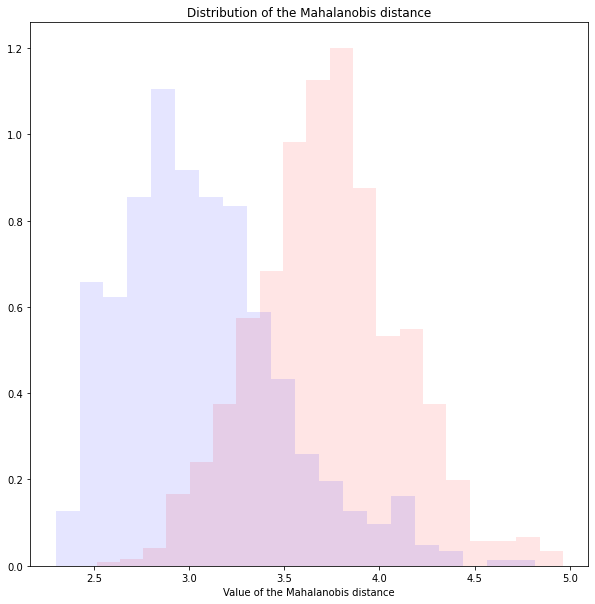

In [ ]:
col = ['r','b']
plt.figure(figsize=(10, 10))
plt.xlabel('Value of the Mahalanobis distance')
plt.title('Distribution of the Mahalanobis distance')

for i in range(2):
    errs_plot = errs[y_test==i]
    plt.hist(errs_plot, 20, density=True, facecolor=col[i], alpha=0.1)
    print("Reconstruction error for label %s : %.6f " % (i, np.mean(errs_plot)))
plt.show()

[7 2 1 ... 4 5 6]
[False False  True ... False False False]


In [ ]:
fpr, tpr, thresholds = roc_curve(y_test==0, errs, drop_intermediate=False)
AUC = auc(fpr, tpr)
plot_AUC(fpr,tpr,AUC,'Mahalanobis distance')